Note: you may need to restart the kernel to use updated packages.
Phishing URLs: 53657 rows
Enron emails:   517401 rows
PhishTank missing values: total=0, cols_with_missing=[]
Enron missing values: total=0, cols_with_missing=[]
Phishing URLs: 53657 rows
Enron emails:   517401 rows
PhishTank missing values: total=0, cols_with_missing=[]
Enron missing values: total=0, cols_with_missing=[]
Unique senders: 20313
Unique senders: 20313


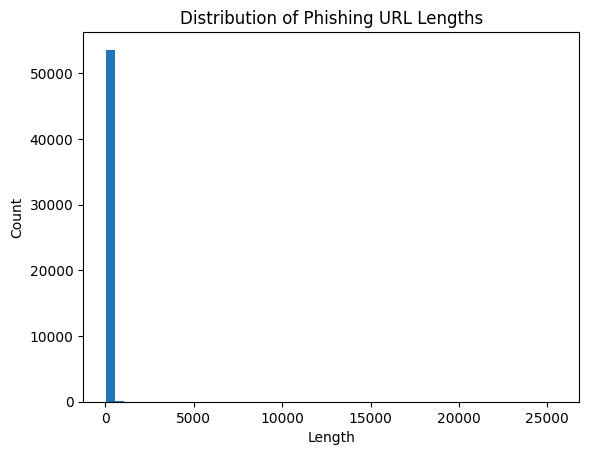

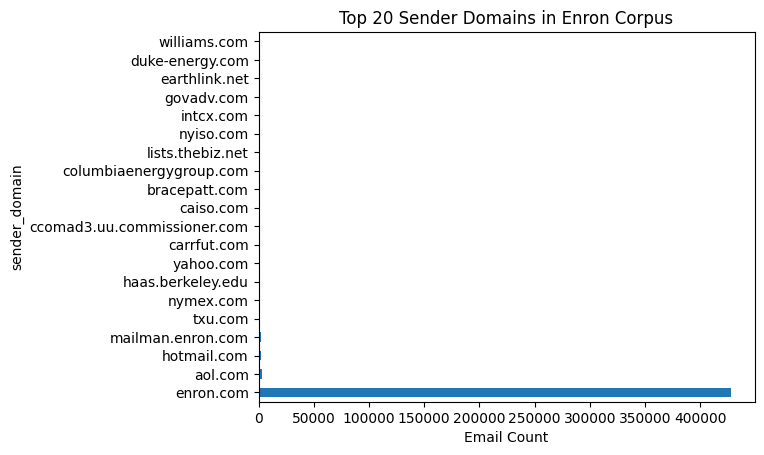

In [1]:
# 01-data-exploration.ipynb
# Data Exploration: PhishTank & Enron

"""
## 01 - Data Exploration

This notebook performs initial exploration of the raw datasets:

1. Load PhishTank phishing URL dump.
2. Load Enron email dataset (parsed CSV).
3. Inspect basic stats (counts, missing values).
4. Quick EDA on URL lengths, creation dates distribution, sender domains.
5. Save summary CSVs for feature development.
"""

#%%
# 1. Imports and Configuration
# Ensure required plotting package is available in the notebook environment
%pip install --quiet matplotlib

import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Set data paths
PHISHANK_CSV = os.path.join('..','data','raw','phishtank_urls.csv')
ENRON_CSV    = os.path.join('..','data','raw','enron_emails','emails.csv')  # after parse_enron

#%%
# 2. Load Data
# Defensive checks: ensure files exist before attempting to read
missing_files = [p for p in (PHISHANK_CSV, ENRON_CSV) if not os.path.exists(p)]
if missing_files:
    raise FileNotFoundError(f"Required data files not found: {missing_files}")

phish_df = pd.read_csv(PHISHANK_CSV)
enron_df = pd.read_csv(ENRON_CSV)

print(f"Phishing URLs: {len(phish_df)} rows")
print(f"Enron emails:   {len(enron_df)} rows")

#%%
# 3. Basic Stats
# Missing values - concise summary: total missing and columns with missing > 0
phish_missing = phish_df.isnull().sum()
phish_missing_total = int(phish_missing.sum())
phish_missing_cols = phish_missing[phish_missing > 0].to_dict()

enron_missing = enron_df.isnull().sum()
enron_missing_total = int(enron_missing.sum())
enron_missing_cols = enron_missing[enron_missing > 0].to_dict()

print(f"PhishTank missing values: total={phish_missing_total}, cols_with_missing={list(phish_missing_cols.keys())}")
print(f"Enron missing values: total={enron_missing_total}, cols_with_missing={list(enron_missing_cols.keys())}")

# Determine sender column or extract from message
if 'sender' in enron_df.columns:
    sender_series = enron_df['sender']
else:
    # attempt to extract 'From:' or 'From ' lines from the raw message text
    def extract_sender(msg):
        if not isinstance(msg, str):
            return None
        # common patterns: 'From: name <addr>' or 'From addr@domain'
        m = re.search(r"From:\s*([^\n<]+<([^>]+)>|[^\n]+)", msg)
        if m:
            # prefer the email address if present
            addr_match = re.search(r"[\w\.-]+@[\w\.-]+", m.group(0))
            if addr_match:
                return addr_match.group(0)
            return m.group(1).strip()
        # fallback: try to find any email-like token in the message
        em = re.search(r"[\w\.-]+@[\w\.-]+", msg)
        if em:
            return em.group(0)
        return None

    sender_series = enron_df['message'].apply(extract_sender)

# attach sender & domain
enron_df['sender'] = sender_series
enron_df['sender_domain'] = enron_df['sender'].dropna().str.extract(r"@(.*)")[0]

print('Unique senders:', enron_df['sender'].nunique())

#%%
# 4. EDA - URL length distribution
phish_df['url_length'] = phish_df['url'].str.len()
plt.hist(phish_df['url_length'], bins=50)
plt.title('Distribution of Phishing URL Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

#%%
# 5. EDA - Sender domain frequency
# extract domain from 'sender' if not already present
if 'sender_domain' not in enron_df.columns or enron_df['sender_domain'].isnull().all():
    enron_df['sender_domain'] = enron_df['sender'].dropna().str.extract(r"@(.*)")[0]

top_senders = enron_df['sender_domain'].value_counts().head(20)
if not top_senders.empty:
    top_senders.plot(kind='barh')
    plt.title('Top 20 Sender Domains in Enron Corpus')
    plt.xlabel('Email Count')
    plt.show()
else:
    print('No sender domains found to plot')

#%%
# 6. Save summaries for feature engineering
phish_df[['url','url_length']].to_csv(os.path.join('..','data','processed','phish_url_summary.csv'), index=False)
enron_df[['sender','sender_domain']].to_csv(os.path.join('..','data','processed','enron_senders.csv'), index=False)
